C:\Users\veoni\anaconda3\envs\HOPLAB\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
C:\Users\veoni\anaconda3\envs\HOPLAB\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)
C:\Users\veoni\anaconda3\envs\HOPLAB\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
C:\Users\veoni\anaconda3\envs\HOPLAB\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  

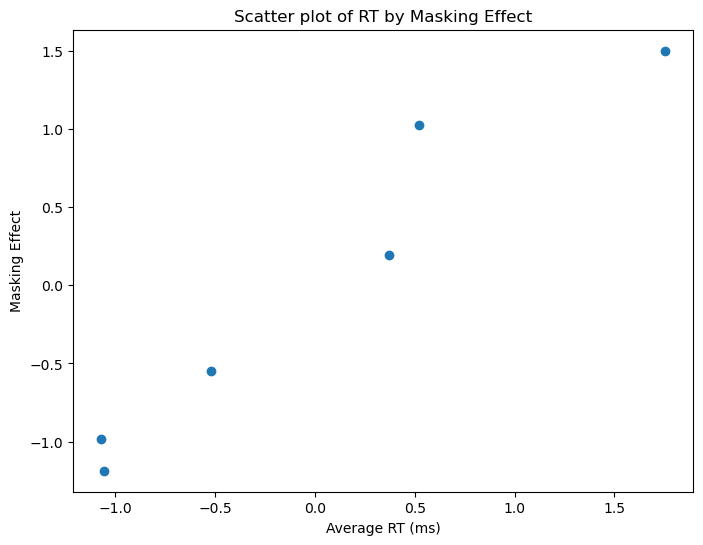

C:\Users\veoni\anaconda3\envs\HOPLAB\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\veoni\anaconda3\envs\HOPLAB\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\veoni\anaconda3\envs\HOPLAB\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\veoni\anaconda3\envs\HOPLAB\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

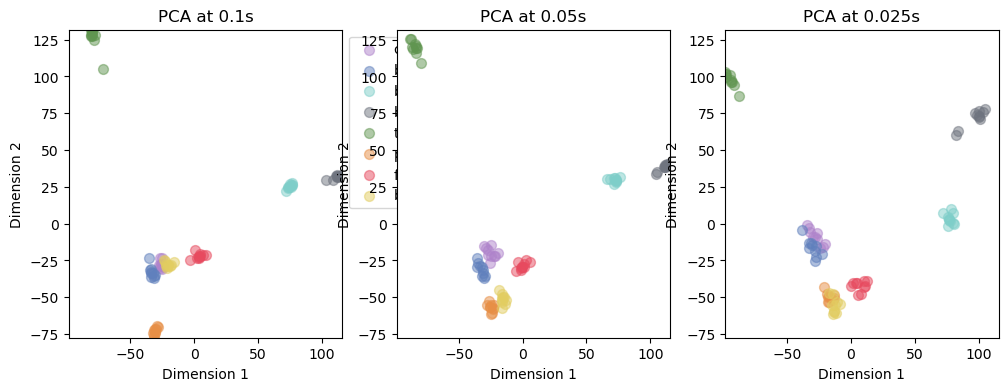

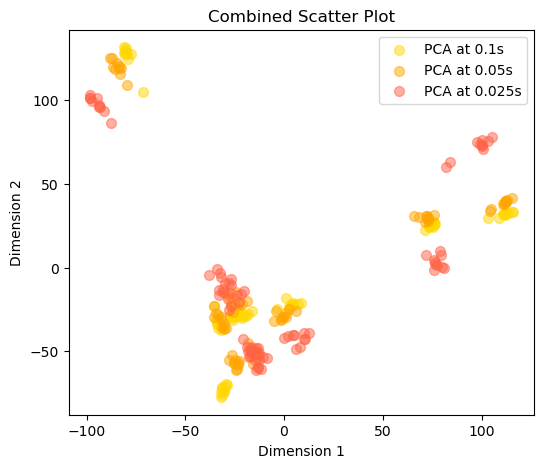

KeyError: "None of [Index(['control', 'low', 'high'], dtype='object', name='difficulty')] are in the [columns]"

In [4]:
'''
Results from the thesis
-----------------------

This script takes input data from a classification task experiment, and
runs a series of analyses on it, from pre-processing to interpretations.

Here is the overall structure that the analyses follow:
 - importing the data, preprocessing it
 - checking for the effects of masking, occluder size, difficulty
 - establishing the role of recurrence by correlating masking effect and
   RT
 - once these effects are established, pushing further with PCA plots
 - going deeper into the occluder size effect: why is it happening?
   -> black pixel count
   -> aperture count
'''


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from sklearn.decomposition import PCA
from pathlib import Path
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix
import pingouin as pg
import scikit_posthocs as sp
import cv2 as cv


# import style sheet
#plt.style.use("./Analysis/styles/mystyle.mplstyle")

# list the data files
data_files = glob.glob(r'../Experiment/data/results*.csv')

# read the data files into a single dataframe
df = pd.concat([pd.read_csv(file) for file in data_files])


### Filter out the data

# select only the main task
df = df.loc[df['task']=='experiment']

# select out the columns
columns_to_keep = ['pt_num', 'trial_nbr', 'block_number', 'rt', 'soa', 'acc', 'category', 'choiced_category',
                   'difficulty', 'size_occl', 'filename','pressed_key', 'correct_key']
# keep only the relevant columns
df = df[columns_to_keep]
# reset the index
df.reset_index(drop=True, inplace=True)

# remove the nan answers
df = df.loc[df['pressed_key']!='NAN']


### Remove outliers

# make a histogram of participants average accuracy
# from there we decide that the cut will be at 0.7

# list outlier participants with averagea ccuracy below 0.7
outlier_ppts = [p for p in df['pt_num'].unique() if df.loc[df['pt_num']==p, 'acc'].mean() < 0.7]
# remove them from the data
df = df.loc[~df['pt_num'].isin(outlier_ppts)]

# make a histogram of trial RTs
# from there we decide of the cutoff quantile

# list the trials with RT above the 99th quantile
ninty_ninth = df["rt"].quantile(0.99)
# drop the trials with RT above this value
df = df.loc[df['rt']<ninty_ninth]

# list the trials with RT below the 0.001th quantile
zero_point_first_quantile = df['rt'].quantile(0.001)
df = df.loc[df['rt']>zero_point_first_quantile]


### ANOVAs


## Main ANOVA: occluder size x masking SOA

# assumption checks: normality is violated (include the test results)
# include the results from the rank-transformed analysis, which are similar

# main ANOVA on RT
main_result = pg.rm_anova(data=df[df['acc']], dv='rt', within=['size_occl', 'soa'], subject= 'pt_num', detailed=True)

# post hoc on RT - SOA
posthoc_soa = sp.posthoc_ttest(df[df['acc']], val_col= "rt", group_col= "soa", p_adjust='bonferroni')

# post hoc on RT - occluder size
posthoc_size_occl = sp.posthoc_ttest(df[df['acc']], val_col= "rt", group_col= "size_occl", p_adjust='bonferroni')

# here you add posthoc comparison graphs
# these graphs show the main effect of occluder size and SOA on RT
# with potential pairwise significant differences (make pointplots with
# significance stars)

# because there is no interaction effect, we don't dig deeper into sub-anovas
# somehow we need to check for the effects of difficulty, we need to think
# about that …


# main ANOVA on accuracy

# paste the results from your assumption checks here - they hold

# make a grouped dataframe with average accuracy per subject and per condition
aov_acc_df = df.groupby(['pt_num', 'size_occl', 'soa'], as_index=False)['acc'].mean()
# run the anova
aov_acc = pg.rm_anova(data=aov_acc_df, dv='acc', within=["size_occl", 'soa'], subject = "pt_num", detailed = True)

# post hoc on accuracy - SOA
posthoc_soa = sp.posthoc_ttest(aov_acc_df, val_col= "acc", group_col= "soa", p_adjust='bonferroni')

# post hoc on accuracy - occluder size
posthoc_size_occl = sp.posthoc_ttest(aov_acc_df, val_col= "acc", group_col= "size_occl", p_adjust='bonferroni')

# here you add posthoc comparison graphs
# try again to make point plots with significance stars to show the pairwise
# differences across levels


## Small occluder size ANOVA


## Large occluder size ANOVA


# do the same for these two last anova sections; assumption checks, then anova, then posthoc tests
# each time try to produce a graph, that should mean one graph per anova (you already have these graphs,
# but I think you should link them to your anovas)
# for sphericity: I think it's good to say 'it's violated to we'll consider the GG-corrected
# values





### Correlating masking effect x RT

# list the tasks and their display names
tasks = {
    'many small_control': 'MS control',
    'many small_low': 'MS low',
    'many small_high': 'MS high',
    'few large_control': 'FL control',
    'few large_low': 'FL low',
    'few large_high': 'FL high'
}
# make a task column
df['task'] = df['size_occl'] + '_' + df['difficulty']
# find out the masking effect and average RT per task
mask_rt_df = pd.DataFrame({
    'task' : [t for t in tasks],
    'masking effect': [np.mean(df.loc[(df['task']==t) & (df['soa']==0.1), 'acc']) - 
                       np.mean(df.loc[(df['task']==t) & (df['soa']==0.025), 'acc']) 
                       for t in tasks],
    'RT' : [np.mean(df.loc[(df['task']==t), 'rt']) for t in tasks]
})
# make a standardised version of the data using x = (x-m)/s
std_mask_rt_df = pd.DataFrame()
for col in ['RT', 'masking effect']:
    std_mask_rt_df[col] = ( mask_rt_df[col] - np.mean(mask_rt_df[col]) ) / np.std(mask_rt_df[col])
std_mask_rt_df['task'] = mask_rt_df['task']
# correlate the results
corr, p_value = pearsonr(mask_rt_df['RT'].values, mask_rt_df['masking effect'].values)

# make a scatterplot of RT x masking effect
plt.figure(figsize=(8, 6))
plt.scatter(std_mask_rt_df['RT'], std_mask_rt_df['masking effect'])
plt.xlabel('Average RT (ms)')
plt.ylabel('Masking Effect')
plt.title('Scatter plot of RT by Masking Effect')
plt.show()




### Category-based analyses

# build a dictionary with category-level confusion matrices
# this is not super useful actually
confmat_dict = {
    size_occl: {soa:
        confusion_matrix(
            y_pred = df.loc[(df['size_occl']==size_occl)&(df['soa']==soa),'choiced_category'],
            y_true = df.loc[(df['size_occl']==size_occl)&(df['soa']==soa),'category'],
            labels = df['category'].unique()
        )
        for soa in df['soa'].unique()}
    for size_occl in df['size_occl'].unique()
}




### Image-based analyses

## build image-wise confusion dataframe per soa

# add an image column
df['image'] = [str(Path(i).stem).split('_')[-1] for i in df['filename']]
# list all the individual images
im_labels = df['image'].unique()
# build the image-wise confusion dictionary per soa
im_cm_dict = {
    soa: {
        c: [ len(df.loc[(df['image']==im)&(df['choiced_category']==c)&(df['soa']==soa)])
            for im in im_labels ]
        for c in df['category'].unique()
    }
    for soa in df['soa'].unique()
}
# build the PCA from there
im_pca_dict = {
    soa: pd.DataFrame(
        {
            'Image': im_labels,
            'Category': pd.Series(im_labels).replace({ # adding a category column
            (fr'^{c}\w+'): c for c in df['category'].unique()
            }, regex = True),
            'Dimension 1': PCA(n_components=2).fit_transform(pd.DataFrame(im_cm_dict[soa]))[:,0],
            'Dimension 2': PCA(n_components=2).fit_transform(pd.DataFrame(im_cm_dict[soa]))[:,1]
        }
    )
    for soa in df['soa'].unique()
}

## Plot the results on three successive plots
# choose category colours
category_palette = {
    "person": "#E78F46",
    "cat": "#AF83CB",
    "bird": "#6080BD",
    "tree": "#609550",
    "banana": "#E2CD61",
    "firehydrant": "#E74A5F",
    "bus": "#7ECEC9",
    "building": "#6F747F"
}

fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Adjust figsize as needed

# Calculate the limits for consistent axes scaling
xmin, xmax, ymin, ymax = float('inf'), float('-inf'), float('inf'), float('-inf')
for df in im_pca_dict.values():
    xmin = min(xmin, df['Dimension 1'].min())
    xmax = max(xmax, df['Dimension 1'].max())
    ymin = min(ymin, df['Dimension 2'].min())
    ymax = max(ymax, df['Dimension 2'].max())

# Plotting each DataFrame in a subplot
for i, (key, df) in enumerate(im_pca_dict.items()):
    ax = axs[i]
    categories = df['Category'].unique()
    
    # Plotting each category separately with custom colors
    for cat in categories:
        cat_data = df[df['Category'] == cat]
        ax.scatter(
            cat_data['Dimension 1'],
            cat_data['Dimension 2'],
            label=cat,
            color=category_palette[cat],
            s=50,
            alpha=0.5
        )
    
    ax.set_title(f'PCA at {key}s')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_xlim(xmin, xmax)  # Constrain X-axis to same values
    ax.set_ylim(ymin, ymax)  # Constrain Y-axis to same values
    
    if key == 0.1:
        ax.legend(bbox_to_anchor=(1.0, 1.0))  # Show legend only for the last plot

plt.show()


## Plot the results on one single plot, overlapping
# Concatenate all DataFrames into a single DataFrame
concatenated_df = pd.concat(im_pca_dict.values(), keys=im_pca_dict.keys())

# Create a scatter plot with distinct colors for each DataFrame
plt.figure(figsize=(6, 5))  # Adjust figsize as needed

for (key, df), color in zip(im_pca_dict.items(), ['gold', 'orange', 'tomato']):
    df = df.reset_index(drop=True)  # Reset index for each DataFrame
    plt.scatter(df['Dimension 1'], df['Dimension 2'], label=f'PCA at {key}s', s=50,color=color, alpha=0.5)

plt.title('Combined Scatter Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()



# the last plots show nicely how masking affect representations and how these
# get more isolate (categories clustering and increasing space with others)
# across time. this being demonstrated, we go deeper into the occluder size
# differences

# we now go deeper into trying to explain the difference between occluder sizes



### Pixel count analyses


# list the input images
occluded_images = glob.glob(r'./Experiment/Stimulus/all_stim/occlusion/partialviewing/*/*/*.png')
object_images = glob.glob(r'./Experiment/Stimulus/objects/*.png')

# extract the directory of the object images
object_dir = r'./Experiment/Stimulus/objects/'

# match each occluded image with its object
matched_images = pd.DataFrame({
    'occluded_images' : [i for i in occluded_images],
    'object_images' : [object_dir + (Path(i).name).split('_')[-1]
                       for i in occluded_images],
    'black pixels' : [(0) for _ in range(len(occluded_images))], # empty column here
    'occluder size' : [(Path(i).name).split('_')[0]
                       for i in occluded_images],
    'difficulty' : [(Path(i).name).split('_')[-2]
                    for i in occluded_images]
})

# loop over all images and calculate black pixels
for i in range(len(occluded_images)): 
    # extract the name of the images
    occluded_file = matched_images['occluded_images'][i]
    object_file = matched_images['object_images'][i]

    # read the images
    occluded_im = cv.imread(occluded_file, -1)
    object_im = cv.imread(object_file, -1)

    # extract the object mask
    object_mask = object_im[:,:,3] == 255

    # remove the object from the count
    im_without_object = occluded_im[~object_mask]

    # count the black pixels
    nb_black_pixels = len(im_without_object[im_without_object == 0])

    # append the results
    matched_images['black pixels'][i] = nb_black_pixels



## Plot the number of black pixels per occluder size

# Group data by 'occluder size' and 'difficulty', calculate mean and standard deviation
grouped_data = matched_images.groupby(['occluder size', 'difficulty'])['black pixels'].agg(['mean', 'std'])
# Pivot table to rearrange data for plotting
pivot_data = grouped_data.reset_index().pivot(index='occluder size', columns='difficulty', values='mean')
# Standard error calculation
pivot_data_err = grouped_data.reset_index().pivot(index='occluder size', columns='difficulty', values='std')
# reorder the columns
pivot_data = pivot_data[['control', 'low', 'high']]
pivot_data_err = pivot_data_err[['control', 'low', 'high']]
# Plotting bar chart with distance and gray outline
ax = pivot_data.plot(kind='bar', yerr=pivot_data_err, figsize=(6, 4), edgecolor='gray', linewidth=1, width=0.7)
plt.title('Black Pixels per Occluder Size with Difficulty Levels')
plt.xlabel('Occluder Size')
plt.ylabel('Black Pixels')
plt.legend(title='Difficulty', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

# add some visualisations here: per level of difficulty, scatterplots of black
# pixels per accuracy with hue on the occluder size

# add your first tests: one linear regression per level of difficulty, with dependent variable
# accuracy and predictor black pixels

# then check, per difficulty level, how accuracy is driven by black pixels (make
# your scatterplots here)



### Aperture counts

# let's drop this part for now